<a href="https://colab.research.google.com/github/borbysh/Momentum-QNG/blob/main/Portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import yfinance as yf

assets = "AAPL MSFT AMZN TSLA GOOG BRK-B"
StockStartDate = '2018-01-01'
StockEndDate = '2018-12-31'
interval = '1d'

df = yf.download(assets, start=StockStartDate,\
                 end=StockEndDate, interval=interval)['Adj Close']

# daily return distribution
ret = df.pct_change().dropna()

# mean return vector & covariance matrix (annualized)
R = ret.mean()*252
Sigma = ret.cov()*252

[*********************100%%**********************]  6 of 6 completed


In [2]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 18.1 MB/s eta 0:00:00


In [3]:
import pennylane as qml
from pennylane import numpy as np

# define parameters in H
N = 6      # number of total assets
gamma = 1  # risk aversion coefficient
B = 3      # budget
P = 1.0    # penalty

ZZ = [qml.PauliZ(i)@qml.PauliZ(j) for i in range(N) for j in range(i+1,N)]
ZZ_coeff = [0.5*(gamma*Sigma.values[i][j] + P) for i in range(N) for j in range(i+1,N)]
Z = [qml.PauliZ(i) for i in range(N)]
Z_coeff = [-0.5*gamma*(sum(Sigma.values[i][:])) + 0.5*R[i] - 0.5*P*(N-2*B) for i in range(N)]
C = 0.25*gamma*(sum(sum(Sigma.values)) + np.trace(Sigma))- 0.5*sum(R) + 0.25*P*(N + (N-2*B)**2)

# Construct the problen Hamiltonian
obs = ZZ + Z
coeffs = ZZ_coeff + Z_coeff
H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")

In [4]:
# Design the ansatz
p = 2     # circuit repetitions
def ansatz(params, qubits, depth=p):
    for q in range(qubits):
            qml.RY(params[q], wires=q)
    for d in range(1,depth+1):
        for q in range(qubits-1):
            qml.CNOT(wires=[q,q+1])
        for q in range(qubits):
            qml.RY(params[d*qubits+q], wires=q)

In [5]:
dev = qml.device("default.qubit", wires=N)

# Set the cost function on dev
@qml.qnode(dev, diff_method="parameter-shift")
def cost(x):
    ansatz(x, qubits=N)
    return qml.expval(H)

# For analyze the optimized circuit
@qml.qnode(dev)
def probability_circuit(params):
    ansatz(params, qubits=N)
    return qml.probs(wires=range(N))

In [6]:
def qng_session(params, stepsize=0.07, steps=300):
  opt = qml.QNGOptimizer(stepsize=stepsize)
  old_cost = 9999.999999
  for i in range(steps):
      params = opt.step(cost, params)
      obj_value = cost(params)
      #cost_qng.append(obj_value)
      if (i + 1) % 5 == 0:
          #print("Cost after step {:5d}: {: .7f}".format(i + 1, obj_value))
          if np.round(old_cost, 7) == np.round(obj_value, 7):
              break
          else:
              old_cost = obj_value
  return params

In [7]:
def momentum_qng_session(params, stepsize=0.07, momentum=0.9, steps=300):
  opt = qml.QNGOptimizer(stepsize=stepsize)
  old_cost = 9999.999999
  prev_step = params*0
  for i in range(steps):
      prev_params = params
      params = opt.step(cost, params) + momentum*prev_step
      prev_step = params - prev_params
      obj_value = cost(params)
      #cost_qng.append(obj_value)
      if (i + 1) % 5 == 0:
          #print("Cost after step {:5d}: {: .7f}".format(i + 1, obj_value))
          if np.round(old_cost, 7) == np.round(obj_value, 7):
              break
          else:
              old_cost = obj_value
  return params



In [8]:
def coolmomentum_qng_session(params, stepsize=0.07, momentum=0.99, steps=300):
  alpha = (1 - momentum)**(1/steps)
  old_cost = 9999.999999
  prev_step = params*0
  for i in range(steps):
      prev_params = params
      rho_i = 1 - (1 - momentum)/(alpha**i)
      lr_i = stepsize * (1 + rho_i) / 2
      opt = qml.QNGOptimizer(stepsize=lr_i)
      params = opt.step(cost, params) + rho_i*prev_step
      prev_step = params - prev_params
      obj_value = cost(params)
      #cost_qng.append(obj_value)
      if (i + 1) % 5 == 0:
          #print("Cost after step {:5d}: {: .7f}".format(i + 1, obj_value))
          if np.round(old_cost, 7) == np.round(obj_value, 7):
              break
          else:
              old_cost = obj_value
  return params

In [9]:
def adam_session(params, stepsize=0.04, steps=300):
  opt = qml.AdamOptimizer(stepsize=stepsize)
  old_cost = 9999.999999
  for i in range(steps):
      params = opt.step(cost, params)
      obj_value = cost(params)
      #cost_qng.append(obj_value)
      if (i + 1) % 5 == 0:
          #print("Cost after step {:5d}: {: .7f}".format(i + 1, obj_value))
          if np.round(old_cost, 7) == np.round(obj_value, 7):
              break
          else:
              old_cost = obj_value
  return params

In [10]:
iterations=300
qng_step = 0.02
adam_step = 0.08
shots=21
best_cost = 9999.9999
qng_cost = []
mqng_cost = []
coolqng_cost = []
adam_cost = []
hits = [0.0, 0.0, 0.0, 0.0]
ground_energy = -1.9083156
for n in range(shots):
    init_params = np.random.rand((p+1)*N)
    params_qng = qng_session(init_params, qng_step, iterations)
    cost_qng = cost(params_qng)
    qng_cost.append(cost_qng)
    if abs(cost_qng - ground_energy) <= 0.01:
      hits[0] += 1/shots

    params_mqng = momentum_qng_session(init_params, qng_step, 0.9, iterations)
    cost_mqng = cost(params_mqng)
    mqng_cost.append(cost_mqng)
    if abs(cost_mqng - ground_energy) <= 0.01:
      hits[1] += 1/shots

    params_coolqng = coolmomentum_qng_session(init_params, qng_step, 0.99, iterations)
    cost_coolqng = cost(params_coolqng)
    coolqng_cost.append(cost_coolqng)
    if abs(cost_coolqng - ground_energy) <= 0.01:
      hits[2] += 1/shots

    params_adam = adam_session(init_params, adam_step, iterations)
    cost_adam = cost(params_adam)
    adam_cost.append(cost_adam)
    if abs(cost_adam - ground_energy) <= 0.01:
      hits[3] += 1/shots
    print("Cost after shot {:5d}: adam: {: .7f}, qng: {: .7f}, mqng: {: .7f}, coolqng: {: .7f}"
          .format(n, cost_adam, cost_qng, cost_mqng, cost_coolqng))
    print(hits)



Cost after shot     0: adam: -1.7171738, qng: -1.6651480, mqng: -1.7183741, coolqng: -1.8544845
[0.0, 0.0, 0.0, 0.0]
Cost after shot     1: adam: -1.6884551, qng: -1.6365379, mqng: -1.9083606, coolqng: -1.9083421
[0.0, 0.047619047619047616, 0.047619047619047616, 0.0]
Cost after shot     2: adam: -1.6528590, qng: -1.6528539, mqng: -1.7171632, coolqng: -1.7122385
[0.0, 0.047619047619047616, 0.047619047619047616, 0.0]
Cost after shot     3: adam: -1.6859617, qng: -1.7168221, mqng: -1.6935187, coolqng: -1.9071382
[0.0, 0.047619047619047616, 0.09523809523809523, 0.0]
Cost after shot     4: adam: -1.6528277, qng: -1.6316081, mqng: -1.9083619, coolqng: -1.9082530
[0.0, 0.09523809523809523, 0.14285714285714285, 0.0]
Cost after shot     5: adam: -1.9083629, qng: -1.8637056, mqng: -1.9083574, coolqng: -1.7213310
[0.0, 0.14285714285714285, 0.14285714285714285, 0.047619047619047616]
Cost after shot     6: adam: -1.7171737, qng: -1.7165770, mqng: -1.7214111, coolqng: -1.9083311
[0.0, 0.142857142857

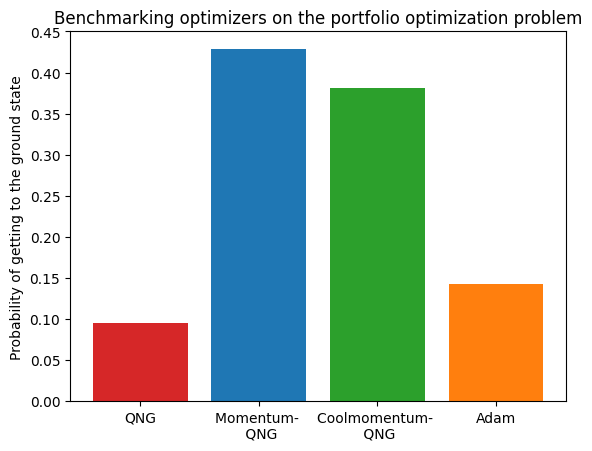

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

optimizers = ['QNG', 'Momentum- \n QNG', 'Coolmomentum- \n QNG', 'Adam']
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']

ax.bar(optimizers, hits, color=bar_colors)

ax.set_ylabel('Probability of getting to the ground state')
ax.set_title('Benchmarking optimizers on the portfolio optimization problem')

plt.show()